# TPTP file data extraction

In [20]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

load_from_file = True
store = False
if load_from_file:
    df_tptp = pd.read_csv("../src/df_tptp.csv", index_col=0)
else:

    def unpack_spc(spc):
        return_values = 6*[None]
        if type(spc) != str:
            return return_values
        spc = spc.strip()
        spc_list = spc.split("_")
        for i in range(5):
            try:
                return_values[i] = spc_list[i]
            except:
                pass
        return return_values

    parameters = {
        "spc":          r"(?<=% SPC      :)(\s+\w+)",
        "n_formulae":   r"(?<=formulae    :)(\s+\d+)",
        "n_atoms":      r"(?<=atoms       :)(\s+\d+)",
        "n_clauses":    r"(?<=clauses     :)(\s+\d+)",
        "n_literals":   r"(?<=literals    :)(\s+\d+)",
        "n_variables":  r"(?<=variables   :)(\s+\d+)",
    }
    problem_configs = []

    problems_dir = "TPTP-v9.0.0/Problems/"
    dir_list = os.listdir(problems_dir)
    for dir_name in tqdm(dir_list, total=len(dir_list)):
        full_dir_name = os.path.join(problems_dir, dir_name)
        downloads_list = os.listdir(full_dir_name)
        for dir_name in downloads_list:
            full_file_name = os.path.join(full_dir_name, dir_name)
            if not os.path.isfile(full_file_name):
                continue
            with open(full_file_name) as full_file_name:
                s_mp_runs = full_file_name.read()
                problem_results: dict = {
                    "Problem": dir_name,
                }
                for identifier, pattern in parameters.items():
                    re_match = re.search(pattern, s_mp_runs)
                    problem_results[identifier] = re_match.group(0) if re_match is not None else None
                problem_results["full_file_name"] = full_file_name.name
                problem_configs.append(problem_results)

    df_tptp = pd.DataFrame.from_records(problem_configs)

    # Unpack spc into subcolumns
    len_spc = df_tptp["spc"].fillna("").apply(len)
    df_tptp.groupby(by=len_spc).first()
    (
        df_tptp["problem_form"],
        df_tptp["expected_szs"],
        df_tptp["logic_order"],
        df_tptp["equality"],
        df_tptp["arithmetic"],
        df_tptp["horness"],
    ) = zip(*df_tptp["spc"].map(unpack_spc))

df_tptp


df_tptp = df_tptp.fillna(value=np.nan)
if store:
    df_tptp.to_csv("../src/df_tptp.csv")


df_tptp

,Problem,spc,n_formulae,n_atoms,n_clauses,n_literals,n_variables,full_file_name,problem_form,expected_szs,logic_order,equality,arithmetic,horness
0,TOP036+4.p,FOF_THM_RFO_SEQ,34431.0,241872.0,NaN,NaN,94759.0,TPTP-v9.0.0/Problems/TOP/TOP036+4.p,FOF,THM,RFO,SEQ,NaN,NaN
1,TOP029+1.p,FOF_THM_RFO_SEQ,109.0,569.0,NaN,NaN,184.0,TPTP-v9.0.0/Problems/TOP/TOP029+1.p,FOF,THM,RFO,SEQ,NaN,NaN
2,TOP042+3.p,FOF_THM_RFO_SEQ,13534.0,83921.0,NaN,NaN,33628.0,TPTP-v9.0.0/Problems/TOP/TOP042+3.p,FOF,THM,RFO,SEQ,NaN,NaN
3,TOP008-1.p,CNF_SAT_RFO_NEQ,NaN,NaN,112.0,339.0,357.0,TPTP-v9.0.0/Problems/TOP/TOP008-1.p,CNF,SAT,RFO,NEQ,NaN,NaN
4,TOP009-1.p,CNF_SAT_RFO_NEQ,NaN,NaN,112.0,339.0,357.0,TPTP-v9.0.0/Problems/TOP/TOP009-1.p,CNF,SAT,RFO,NEQ,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26272,MED007+1.p,FOF_THM_RFO_NEQ,41.0,201.0,NaN,NaN,96.0,TPTP-v9.0.0/Problems/MED/MED007+1.p,FOF,THM,RFO,NEQ,NaN,NaN
26273,MED006+1.p,FOF_THM_RFO_NEQ,41.0,197.0,NaN,NaN,95.0,TPTP-v9.0.0/Problems/MED/MED006+1.p,FOF,THM,RFO,NEQ,NaN,NaN
26274,MED012+1.p,FOF_SAT_RFO_NEQ,40.0,190.0,NaN,NaN,93.0,TPTP-v9.0.0/Problems/MED/MED012+1.p,FOF,SAT,RFO,NEQ,NaN,NaN
26275,MED008+1.p,FOF_THM_RFO_NEQ,41.0,197.0,NaN,NaN,95.0,TPTP-v9.0.0/Problems/MED/MED008+1.p,FOF,THM,RFO,NEQ,NaN,NaN


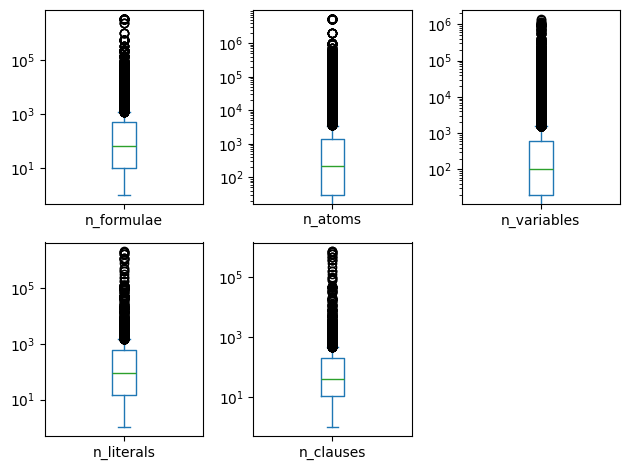

In [2]:
import matplotlib.pyplot as plt
(
    df_tptp
    [["n_formulae", "n_atoms", "n_variables", "n_literals", "n_clauses"]]
    .apply(lambda x: x[x.notnull() & x.notna()])
    .astype(float)
    .plot(kind="box", subplots=True, layout=(2,3), logy=True)
)
plt.tight_layout()
